<h2><b>Main task analysis - excluding outliers</b></h2>
<p>Takes the summary table from the task analysis and tests H1a - <b>regressive errors are reduced and perseverative errors are increased in disgust learning</b></p>
<p>Exactly the same as the analyses done before but excluding outliers this time </p>
<p> Includes:</p>
<li>Hypothesis testing
<li>Model assumption tests 
<li>Adding covariates
<li>Adding video rating scores
<li>Bayesian t-tests to assess strength of any null findings
<li>Follow-up, win-stay/lose-shift analyses
<br>
<p>NB this current version is run on fake data - randomly generated so won't see any expected effects

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import jsonlines
from functools import reduce
import statistics
import scipy.stats
import seaborn as sns
import math
import os
import json
import ast
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pingouin as pg
import warnings
from scipy.stats import ttest_rel
#from statannotations.Annotator import Annotator
from scipy.stats import skew
from statsmodels.stats.diagnostic import het_white
from sklearn.preprocessing import PowerTransformer
import statannot
from scipy.stats import ttest_ind
import itertools

from dataclean_func import *
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.copy_on_write = True

In [91]:
task_summary=pd.read_csv('csvs/task_summary_dummy.csv')
#df.drop(['Unnamed: 0', 'index'], axis="columns", inplace=True)

<h3><b>Exclude outliers from the dataframe</b></h3>
<p>Outliers defined as >1.5 IQR below LQ or above UQ

In [92]:
#create outliers df --> removing those >1.5 IQRs above or below UQ and LQ
for col in task_summary.select_dtypes(include=np.number).columns:
    task_summary=replace_outliers_with_nan(task_summary, col)

#check for outliers - this dataframe only has one outlier in the mean regressive error outcome
task_summary[task_summary.isna().any(axis=1)]

,Unnamed: 0,percentage_correct,mean_perseverative_er,mean_regressive_er,win_stay,lose_shift,block_no,block_type,disgust_block,fear_block,points_block,participant_no,prolific_age,prolific_sex,digit_span
25,25,0.684696,7.625754,NaN,9.265103,7.904819,2.0,Fear,0,1,0,9.0,25,Male,1


<h3><b>Main hypothesis test</b></h3>
<p>Testing whether there are differences in perseverative and regressive errors across block type </p>
<p>Models to run: </p>
<li> 1) 'mean_perseverative_er ~ block_type + age + sex + digit span'
<li> 2) 'mean_regressive_er ~ block_type + age + sex + digit_span'

<b> MODEL 1: PERSEVERATIVE ERRORS </b>

Firstly - check the outcome for skewness

Perseverative error skew: -0.24465583278566425


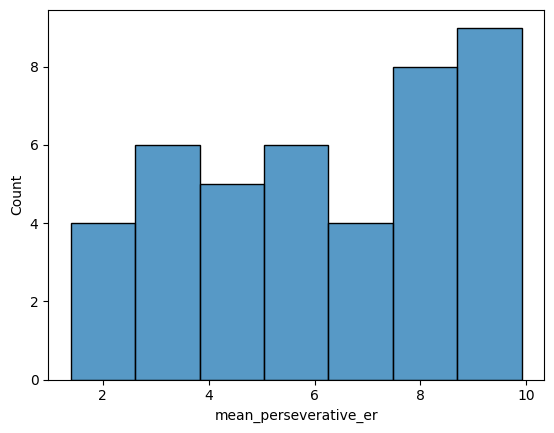

In [93]:
sns.histplot(data=task_summary, x="mean_perseverative_er") 
print('Perseverative error skew: '+str(skew(task_summary.mean_perseverative_er)))
#if skew isn't greater than 0.5 or less than -0.5 then nothing needs to be done
    #for an example of a skewed outcome (and what we would do) see regressive errors section

Now run the initial hypothesis testing model

In [94]:
data=task_summary.reset_index()
data=data.replace(['Disgust', 'Fear', 'Points'], [1.0,2.0,3.0])
formula = 'mean_perseverative_er ~ block_type+prolific_age+prolific_sex+digit_span'
md=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
results1 = md.fit()
print(results1.summary())

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: mean_perseverative_er
No. Observations: 42      Method:             REML                 
No. Groups:       14      Scale:              6.7159               
Min. group size:  3       Log-Likelihood:     -99.6841             
Max. group size:  3       Converged:          Yes                  
Mean group size:  3.0                                              
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 6.848    1.685  4.064 0.000  3.545 10.151
prolific_sex[T.Male]      0.831    0.967  0.859 0.390 -1.064  2.725
block_type                0.060    0.490  0.122 0.903 -0.900  1.020
prolific_age             -0.009    0.040 -0.226 0.821 -0.087  0.069
digit_span               -0.235    0.172 -1.368 0.171 -0.572  0

If covariates (age, sex, working memory) are not significant, remove them from the analysis in order to maximise power.

In [95]:
#e.g., if only working memory and sex have significant effects, remove age as a covariate
data=task_summary.reset_index()
data=data.replace(['Disgust', 'Fear', 'Points'], [1.0,2.0,3.0])
formula = 'mean_perseverative_er ~ block_type+prolific_sex+digit_span'
md=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
results2 = md.fit()
print(results2.summary())

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: mean_perseverative_er
No. Observations: 42      Method:             REML                 
No. Groups:       14      Scale:              6.6533               
Min. group size:  3       Log-Likelihood:     -97.3847             
Max. group size:  3       Converged:          Yes                  
Mean group size:  3.0                                              
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 6.592    1.229  5.363 0.000  4.183  9.001
prolific_sex[T.Male]      0.753    0.874  0.862 0.389 -0.959  2.465
block_type                0.060    0.487  0.122 0.903 -0.896  1.015
digit_span               -0.242    0.164 -1.480 0.139 -0.563  0.079
Group Var                 0.000    0.445                       

C:\Users\eb08\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Will (regardless of outcome) also report on the model without covariates - for completion

In [96]:
data=task_summary.reset_index()
data=data.replace(['Disgust', 'Fear', 'Points'], [1.0,2.0,3.0])
formula = 'mean_perseverative_er ~ block_type'
md=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
results3 = md.fit()
print(results3.summary())

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: mean_perseverative_er
No. Observations: 42      Method:             REML                 
No. Groups:       14      Scale:              6.7006               
Min. group size:  3       Log-Likelihood:     -98.3364             
Max. group size:  3       Converged:          Yes                  
Mean group size:  3.0                                              
----------------------------------------------------------------------
               Coef.    Std.Err.      z      P>|z|    [0.025    0.975]
----------------------------------------------------------------------
Intercept      6.088       1.057    5.761    0.000     4.017     8.159
block_type     0.060       0.489    0.122    0.903    -0.899     1.018
Group Var      0.000       0.414                                      



C:\Users\eb08\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Next, perform post-hoc tests to interpret any significant results

In [97]:
##do so using this function 
def post_hoc_stats(df, independent_var, dependent_var):
    #drop any participants with missing data on the dependent variable
    to_exclude=list(df[pd.isna(df[dependent_var])].participant_no)
    for participant in to_exclude:
        df=df[df['participant_no'] != participant]
    post_hoc =[]
    if independent_var=='block_type' or independent_var=='prolific_sex': ##categorical variables
        conditions=df[independent_var].unique()
        pairs=list(itertools.combinations(conditions, 2))

        for pair in pairs:
            condition1= df[df[independent_var]==pair[0]][dependent_var]
            condition2= df[df[independent_var]==pair[1]][dependent_var]

            if independent_var=='block_type': ##related t-test
                t_stat, p_value=ttest_rel(condition1, condition2)
                post_hoc.append((pair[0], pair[1], t_stat, p_value))
            elif independent_var=='prolific_sex': ##independent t-test
                t_stat, p_value=ttest_ind(condition1, condition2)
                post_hoc.append((pair[0], pair[1], t_stat, p_value))
        post_hoc=pd.DataFrame(post_hoc, columns=['condition1', 'condition2', 't_stat', 'p_value'])
        #Bonferroni corrections for multiple comparisons
        n_comparisons=len(post_hoc.index)
        post_hoc['corrected_p_value']=post_hoc['p_value']*n_comparisons
        post_hoc.loc[post_hoc['corrected_p_value']>1, 'corrected_p_value']=1
    else: ##correlations for continuous variables
        r, p= scipy.stats.pearsonr(df[dependent_var], df[independent_var])
        post_hoc.append((independent_var, r, p))
        post_hoc=pd.DataFrame(post_hoc, columns=['independent_var', 'r_stat', 'p_value'])
    return post_hoc

In [98]:
##e.g., if there was a significant effect of feedback type
post_hoc_stats(task_summary, 'block_type', 'mean_perseverative_er')

,condition1,condition2,t_stat,p_value,corrected_p_value
0,Disgust,Fear,-0.662743,0.519073,1.0
1,Disgust,Points,-0.142782,0.888652,1.0
2,Fear,Points,0.549428,0.592025,1.0


In [99]:
#a significant effect of sex
post_hoc_stats(task_summary, 'prolific_sex', 'mean_perseverative_er')

,condition1,condition2,t_stat,p_value,corrected_p_value
0,Male,Female,0.307947,0.759721,0.759721


In [100]:
#or of age --> a continuous variable so use correlation analysis not a t-test
post_hoc_stats(task_summary, 'prolific_age', 'mean_perseverative_er')

,independent_var,r_stat,p_value
0,prolific_age,-0.048787,0.758981


<h4>Test the assumptions of the final model</h4> 
<p>The model we are basing our conclusions on
<p>(usually will be model 2 -->hypothesis test with only the significant covariates)

Statistic 0.9481332695897533
p-value 0.055384066526514134


Text(0.5, 1.0, 'Q-Q Plot')

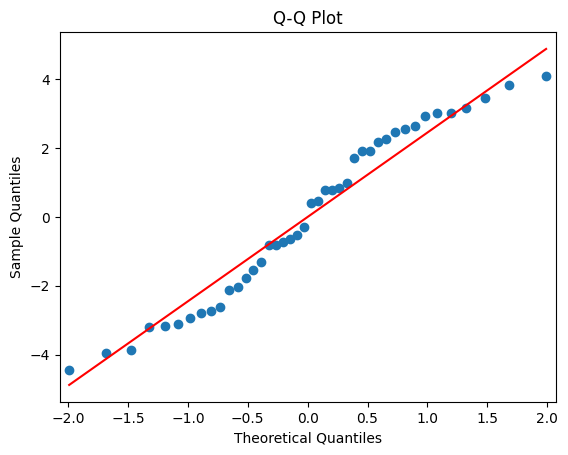

In [101]:
#chose the model we are testing 
results=results2

#shapiro-Wilk test of normality of residuals
labels = ["Statistic", "p-value"]
norm_res = stats.shapiro(results.resid)

for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)
    ##if test is significant then the assumption is violated

## Q-Q PLot
fig = plt.figure()
ax = fig.add_subplot(111)

sm.qqplot(results.resid, dist = stats.norm, line = 's', ax = ax)

ax.set_title("Q-Q Plot")

LM Statistic 8.730086205753938
LM-Test p-value 0.36557476922010795
F-Statistic 1.0824075415838048
F-Test p-value 0.3992288377628533


Text(0, 0.5, 'Residuals')

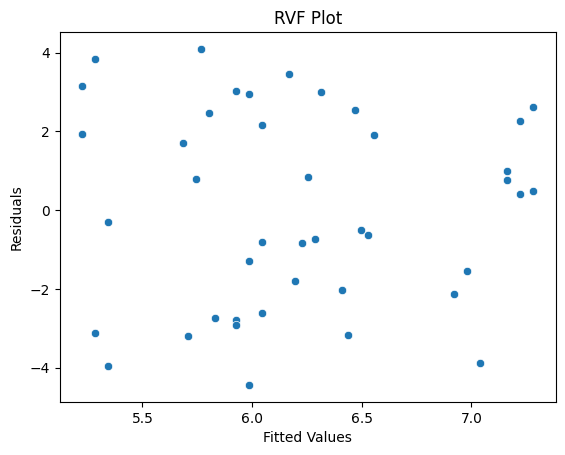

In [102]:
##homoskedasticity of variance 
#White Lagrange Multiplier Test for Heteroscedasticity
het_white_res = het_white(results.resid, results.model.exog)

labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]

for key, val in dict(zip(labels, het_white_res)).items():
    print(key, val)
    ##again, only violated if you get a significant p value (which we don't have here)

#RVF plot (residuals vs fitted values)
fig = plt.figure()
ax = sns.scatterplot(y = results.resid, x = results.fittedvalues)

ax.set_title("RVF Plot")
ax.set_xlabel("Fitted Values")
ax.set_ylabel("Residuals")

<h4>Computing Bayes factor to see strength of the null</h4>
<li>This part is very much dependent on the outcome of the hypothesis test
<li>e.g., if there is no difference between fear and disgust in the hypothesis test --> will follow this up with a Bayesian t-test to see the strength of the null for this key comparison
<br>
<br>
<p>Will interpret this bayes factor using Figure 4 from:
<p>Van Doorn, Johnny & van den Bergh, Don & Boehm, Udo & Dablander, Fabian & Derks, Koen & Draws, Tim & Evans, Nathan & Gronau, Quentin & Hinne, Max & Kucharský, Šimon & Ly, Alexander & Marsman, Maarten & Matzke, Dora & Raj, Akash & Sarafoglou, Alexandra & Stefan, Angelika & Voelkel, Jan & Wagenmakers, Eric-Jan. (2019). The JASP Guidelines for Conducting and Reporting a Bayesian Analysis. Psychonomic Bulletin and Review. 10.3758/s13423-020-01798-5

In [103]:
##create a function to do this using the pinguouin package
        #NB for simplicity just doing pair-wise t-tests for key conditions
def bayes_factor(df, dependent_var, condition_1_name, condition_2_name):
    to_exclude=list(df[pd.isna(df[dependent_var])].participant_no)
    for participant in to_exclude:
        df=df[df['participant_no'] != participant]
    condition1=task_summary[task_summary.block_type==condition_1_name][dependent_var]
    condition2=task_summary[task_summary.block_type==condition_2_name][dependent_var]

    ttest=pg.ttest(condition1, condition2, paired=True)
    bf_null=1/float(ttest.BF10) ##convert this into a bayes factor for the strength of the null
    return bf_null

In [104]:
bayes_factor(task_summary, 'mean_perseverative_er', 'Fear', 'Disgust')

3.058103975535168

In [105]:
bayes_factor(task_summary, 'mean_perseverative_er', 'Fear', 'Points')

3.2467532467532467

In [106]:
bayes_factor(task_summary, 'mean_perseverative_er', 'Fear', 'Points')

3.2467532467532467

<b> MODEL 2: REGRESSIVE ERRORS </b>
<p> Same again but with regressive rather than perseverative errors</p>
<p> This time I have made the outcome variable skewed so show how this would be dealth with </p>

Firstly - check the outcome for skewness

Regressive error skew: 0.7441454483405977


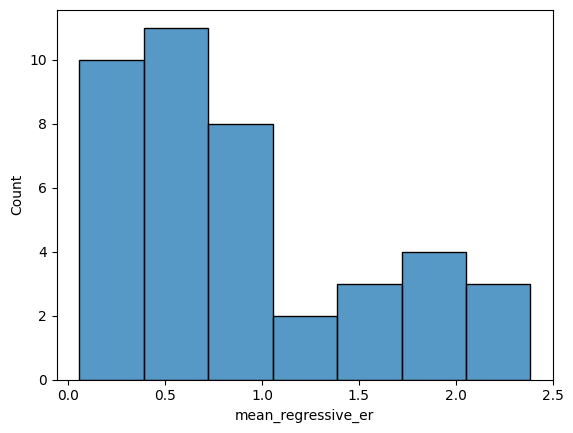

In [107]:
##Model assumptions - skew of distribution
    #data was created to be a skewed distribution - so skew value >0.5
sns.histplot(data=task_summary, x="mean_regressive_er") 
print('Regressive error skew: '+str(skew(task_summary.mean_regressive_er,  nan_policy='omit')))

Given that the distribution was skewed, must perform a transformation

<Axes: xlabel='regressive_er_transformed', ylabel='Count'>

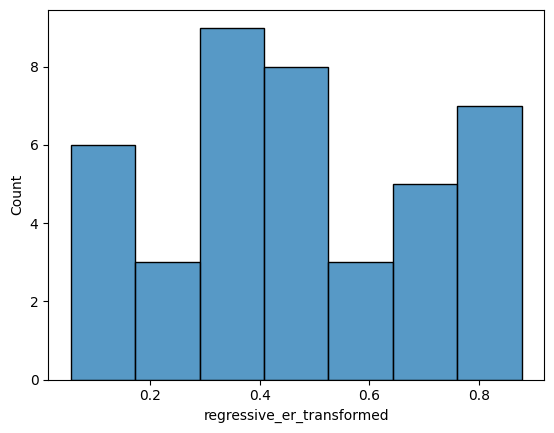

In [108]:
#All further analyses will be done on this transformed variable
pt=PowerTransformer(method='yeo-johnson', standardize=False)
skl_yeojohnson=pt.fit(pd.DataFrame(task_summary.mean_regressive_er))
skl_yeojohnson=pt.transform(pd.DataFrame(task_summary.mean_regressive_er))
task_summary['regressive_er_transformed'] = pt.transform(pd.DataFrame(task_summary.mean_regressive_er))
sns.histplot(data=task_summary['regressive_er_transformed'])

Now run the hypothesis testing model on the transformed variable

In [109]:
data=task_summary.reset_index()
data=data.replace(['Disgust', 'Fear', 'Points'], [1.0,2.0,3.0])
formula = 'regressive_er_transformed ~ block_type+prolific_age+prolific_sex+digit_span'
md=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
results1 = md.fit()
print(results1.summary())

                 Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: regressive_er_transformed
No. Observations: 41      Method:             REML                     
No. Groups:       14      Scale:              0.0604                   
Min. group size:  2       Log-Likelihood:     -12.7350                 
Max. group size:  3       Converged:          Yes                      
Mean group size:  2.9                                                  
------------------------------------------------------------------------
                         Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------------------
Intercept                 0.464     0.166   2.787  0.005   0.138   0.790
prolific_sex[T.Male]      0.099     0.098   1.010  0.312  -0.093   0.292
block_type               -0.029     0.046  -0.620  0.535  -0.120   0.062
prolific_age              0.002     0.004   0.446  0.655  -0.006   0.010
di

C:\Users\eb08\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


If covariates (age, sex, working memory) are not significant, remove them from the analysis in order to maximise power.

In [110]:
#e.g., if only working memory and sex have significant effects, remove age as a covariate
data=task_summary.reset_index()
data=data.replace(['Disgust', 'Fear', 'Points'], [1.0,2.0,3.0])
formula = 'regressive_er_transformed ~ block_type+prolific_sex+digit_span'
md=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
results2 = md.fit()
print(results2.summary())

                 Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: regressive_er_transformed
No. Observations: 41      Method:             REML                     
No. Groups:       14      Scale:              0.0602                   
Min. group size:  2       Log-Likelihood:     -8.2103                  
Max. group size:  3       Converged:          Yes                      
Mean group size:  2.9                                                  
------------------------------------------------------------------------
                         Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------------------
Intercept                 0.515     0.119   4.344  0.000   0.283   0.747
prolific_sex[T.Male]      0.116     0.087   1.328  0.184  -0.055   0.287
block_type               -0.029     0.046  -0.621  0.535  -0.120   0.062
digit_span               -0.013     0.016  -0.786  0.432  -0.045   0.019
Gr

C:\Users\eb08\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Will (regardless of outcome) also report on the model without covariates - for completion

In [111]:
data=task_summary.reset_index()
data=data.replace(['Disgust', 'Fear', 'Points'], [1.0,2.0,3.0])
formula = 'regressive_er_transformed ~ block_type'
md=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
results3 = md.fit()
print(results3.summary())

                 Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: regressive_er_transformed
No. Observations: 41      Method:             REML                     
No. Groups:       14      Scale:              0.0605                   
Min. group size:  2       Log-Likelihood:     -4.3165                  
Max. group size:  3       Converged:          Yes                      
Mean group size:  2.9                                                  
--------------------------------------------------------------------------
                 Coef.     Std.Err.      z       P>|z|    [0.025    0.975]
--------------------------------------------------------------------------
Intercept         0.529       0.101     5.253    0.000     0.332     0.727
block_type       -0.029       0.046    -0.619    0.536    -0.120     0.062
Group Var         0.001       0.041                                       



C:\Users\eb08\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Next, perform post-hoc tests to interpret any significant results

In [112]:
#Using the same function as above
##e.g., if there was a significant effect of feedback type
post_hoc_stats(task_summary, 'block_type', 'regressive_er_transformed')

,condition1,condition2,t_stat,p_value,corrected_p_value
0,Disgust,Fear,0.634021,0.537965,1.0
1,Disgust,Points,0.269927,0.791803,1.0
2,Fear,Points,-0.359993,0.725109,1.0


C:\Users\eb08\AppData\Local\Temp\ipykernel_13760\3725866060.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
C:\Users\eb08\AppData\Local\Temp\ipykernel_13760\3725866060.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)


Text(0.5, 1.0, 'Perseverative errors')

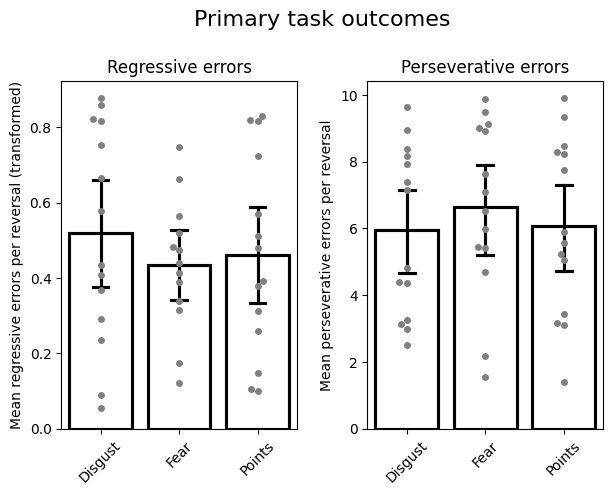

In [113]:
##NB plotting the data will also be used to help interpret results
#example plot:
fig, axes = plt.subplots(1,2, sharey=False)
title="Primary task outcomes"
plt.suptitle(title, fontsize=16)
#fig.set_size_inches(15, 5)
fig.tight_layout(pad=2)

sns.swarmplot(data=task_summary, x="block_type", y="regressive_er_transformed", ax=axes[0], color=".5", size=5, )
sns.barplot(data=task_summary, x="block_type", y="regressive_er_transformed", ax=axes[0], errorbar=('ci', 95), fill=False, color="0", capsize=.2)
#axes[0].set_xlabel("Feedback type")
axes[0].set_xlabel("")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].set_ylabel("Mean regressive errors per reversal (transformed)") 
axes[0].set_title("Regressive errors") 

sns.swarmplot(data=task_summary, x="block_type", y="mean_perseverative_er", ax=axes[1], color=".5", size=5)
sns.barplot(data=task_summary, x="block_type", y="mean_perseverative_er", ax=axes[1], errorbar=('ci', 95), fill=False, color="0", capsize=.2)
#axes[1].set_xlabel("Feedback type")
axes[1].set_xlabel("")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].set_ylabel("Mean perseverative errors per reversal") 
axes[1].set_title("Perseverative errors") 

Test the assumptions of this final model

Statistic 0.9734710634387348
p-value 0.4442544245171136


Text(0.5, 1.0, 'Q-Q Plot')

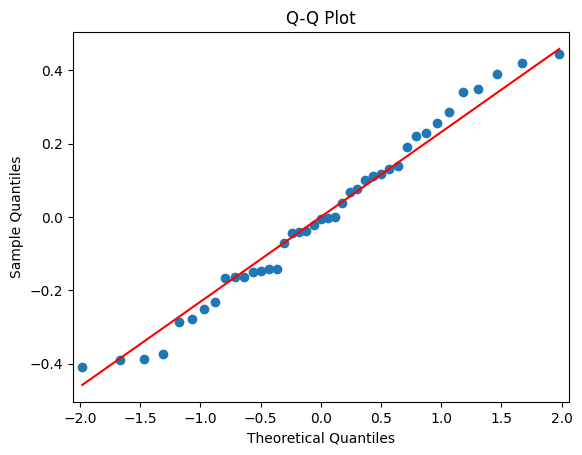

In [114]:
#chose model testing
results=results2

#shapiro-Wilk test of normality of residuals
labels = ["Statistic", "p-value"]
norm_res = stats.shapiro(results.resid)

for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)
    ##if test is significant then the assumption is violated
        #not significant here - so that is good!

## Q-Q PLot
fig = plt.figure()
ax = fig.add_subplot(111)

sm.qqplot(results.resid, dist = stats.norm, line = 's', ax = ax)

ax.set_title("Q-Q Plot")

LM Statistic 6.452950845289559
LM-Test p-value 0.5966309464278803
F-Statistic 0.7471492938678045
F-Test p-value 0.6501265919493576


Text(0, 0.5, 'Residuals')

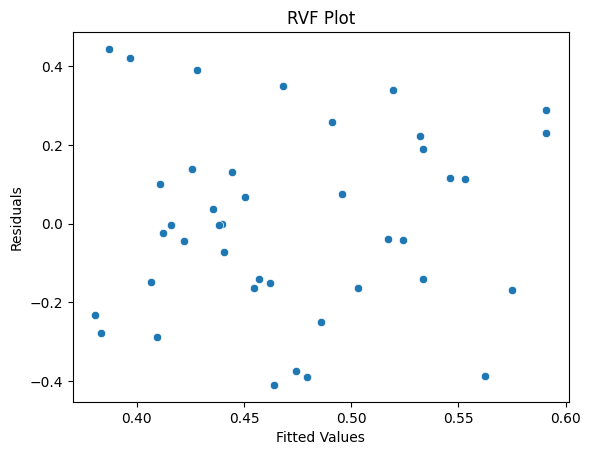

In [115]:
##homoskedasticity of variance 
#White Lagrange Multiplier Test for Heteroscedasticity
het_white_res = het_white(results.resid, results.model.exog)

labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]

for key, val in dict(zip(labels, het_white_res)).items():
    print(key, val)
    ##again, only violated if you get a significant p value (which we don't have here)

#RVF plot (residuals vs fitted values)
fig = plt.figure()
ax = sns.scatterplot(y = results.resid, x = results.fittedvalues)

ax.set_title("RVF Plot")
ax.set_xlabel("Fitted Values")
ax.set_ylabel("Residuals")

Compute the Bayes factors for any null finding

In [116]:
bayes_factor(task_summary, 'regressive_er_transformed', 'Fear', 'Points')

3.4013605442176873

<h3><b>Adding video ratings</b></h3>
<p>Testing whether this result is modified by adding video ratings: </p>
<p>=models 3 and 4 in the analysis plan
<p><b>ONLY TO BE RUN IF RESULTS OF VIDEO RATINGS WARRANT IT</b>
<li>If there is a difference in valence and arousal across fear and disgusting videos: add this difference as a covariate (fear(T1)-disgust(T1))
<li>If there is a difference in habituation between fear and disgusting videos: add this difference in habituation as a covariate (Fear(T1-T2) - Disgust(T1-T2))

Firstly calculate the relevant values and add to the dataframe

In [117]:
##add these values to the dataframe
chosen_stim_df = pd.read_csv("csvs/chosen_stim_dummy.csv")
stim_ratings_covariates=pd.DataFrame()
for participant_no in set(chosen_stim_df.participant_no):
    participant_df=chosen_stim_df[chosen_stim_df.participant_no==participant_no]
    disgust=participant_df[participant_df.trial_type=="disgust"]
    fear=participant_df[participant_df.trial_type=="fear"]
    #difference scores - fear(T1)- disgust(T1)
    valence_diff=int(fear.unpleasant_1)-int(disgust.unpleasant_1)
    arousal_diff=int(fear.arousing_1)-int(disgust.arousing_1)

    #habituation scores- fear(T1-T2)- Disgust(T1-T2)
    valence_habdiff=(int(fear.unpleasant_1)-int(fear.unpleasant_2))-(int(disgust.unpleasant_1)-int(disgust.unpleasant_2))
    arousal_habdiff=(int(fear.arousing_1)-int(fear.arousing_2))-(int(disgust.arousing_1)-int(disgust.arousing_2))
    
    row=pd.DataFrame({
        'participant_no': [participant_no],
        'valence_diff': [valence_diff],
        'arousal_diff': [arousal_diff],
        'valence_habdiff': [valence_habdiff],
        'arousal_habdiff': [arousal_habdiff],
    })
    stim_ratings_covariates=pd.concat([stim_ratings_covariates, row])
task_and_ratings_summary=pd.merge(task_summary, stim_ratings_covariates, on='participant_no', how='outer')

Now add to the mixed effects models: again only running models that are necessary (determined in the video_ratings_analysis)
<p>Start with perseverative errors (model 3)</p>

<b> MODEL 3: PERSEVERATIVE ERRORS W VIDEO RATINGS </b>

In [118]:
#e.g., if there was a difference in valence habituation and baseline arousal
# identified by a difference in valence habituation (valence_habdiff)
        #i.e., a time*stimulus type interaction in valence model (model A)
# and an effect of stimulus type in arousal model (model B)
#so add valence_habdiff and arousal_diff to the model as covariates

data=task_and_ratings_summary
data=data.replace(['Disgust', 'Fear', 'Points'], [1.0,2.0,3.0])
formula = 'mean_perseverative_er ~ block_type + prolific_age + prolific_sex + digit_span + arousal_diff + valence_habdiff'
md=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
results1 = md.fit()
print(results1.summary())

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: mean_perseverative_er
No. Observations: 42      Method:             REML                 
No. Groups:       14      Scale:              6.8398               
Min. group size:  3       Log-Likelihood:     -101.4346            
Max. group size:  3       Converged:          Yes                  
Mean group size:  3.0                                              
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 6.873    1.721  3.993 0.000  3.500 10.246
prolific_sex[T.Male]      0.759    0.967  0.785 0.432 -1.137  2.655
block_type                0.060    0.494  0.121 0.904 -0.909  1.028
prolific_age             -0.016    0.044 -0.360 0.719 -0.103  0.071
digit_span               -0.210    0.189 -1.110 0.267 -0.582  0

C:\Users\eb08\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eb08\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


In [119]:
#again checking assumptions

#chose model
results=results1

#shapiro-Wilk test of normality of residuals
labels = ["Statistic", "p-value"]
norm_res = stats.shapiro(results.resid)

for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)
    ##if test is significant then the assumption is violated
        #is significant here

##homoskedasticity of variance 
#White Lagrange Multiplier Test for Heteroscedasticity
het_white_res = het_white(results.resid, results.model.exog)

labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]

for key, val in dict(zip(labels, het_white_res)).items():
    print(key, val)
    ##again, only violated if you get a significant p value

Statistic 0.959728696651539
p-value 0.1444173580861332
LM Statistic 21.255563836778197
LM-Test p-value 0.3822299098228919
F-Statistic 1.0758712289411705
F-Test p-value 0.43362635900241814


<b> MODEL 4: REGRESSIVE ERRORS W VIDEO RATINGS </b>

Do the same for regressive errors

In [120]:
#e.g., same scenario as above
#note still using transformed outcome variable (as it is skewed)

data=task_and_ratings_summary
data=data.replace(['Disgust', 'Fear', 'Points'], [1.0,2.0,3.0])
formula = 'regressive_er_transformed ~ block_type + prolific_age + prolific_sex + digit_span + arousal_diff + valence_habdiff'
md=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
results1 = md.fit()
print(results1.summary())

                 Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: regressive_er_transformed
No. Observations: 41      Method:             REML                     
No. Groups:       14      Scale:              0.0550                   
Min. group size:  2       Log-Likelihood:     -16.8357                 
Max. group size:  3       Converged:          No                       
Mean group size:  2.9                                                  
------------------------------------------------------------------------
                         Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------------------
Intercept                 0.557     0.157   3.545  0.000   0.249   0.865
prolific_sex[T.Male]      0.127     0.089   1.424  0.154  -0.048   0.302
block_type               -0.029     0.044  -0.650  0.516  -0.116   0.058
prolific_age             -0.003     0.004  -0.735  0.463  -0.011   0.005
di

C:\Users\eb08\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eb08\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\eb08\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eb08\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\eb08\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\mode

In [121]:
#again checking assumptions
#chose model
results=results1

#shapiro-Wilk test of normality of residuals
labels = ["Statistic", "p-value"]
norm_res = stats.shapiro(results.resid)

for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)
    ##if test is significant then the assumption is violated
        #is significant here

##homoskedasticity of variance 
#White Lagrange Multiplier Test for Heteroscedasticity
het_white_res = het_white(results.resid, results.model.exog)

labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]

for key, val in dict(zip(labels, het_white_res)).items():
    print(key, val)
    ##again, only violated if you get a significant p value

Statistic 0.9824468250671182
p-value 0.7673773803001056
LM Statistic 17.700238347757164
LM-Test p-value 0.6071476074234707
F-Statistic 0.7596746529831279
F-Test p-value 0.7277578869122696


<h3><b>Win-stay/lose-shift analyses</b></h3>
<p>Only to be run if there are differences in regressive or perseverative errors across the block types (significant effects of block type in models 1 or 2)</p>
<p>Models to run: </p>
<li> 5) 'win_stay ~ block_type + any covariates that were significant in models 1 and 2'
<li> 6) 'lose_shift ~ block_type + any covariates that were significant in models 1 and 2'

<b> MODEL 5: WIN-STAY </b>

Win-stay  skew: 0.17518763450050448


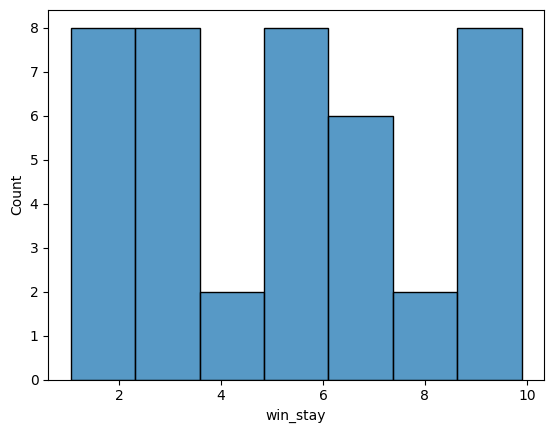

In [122]:
sns.histplot(data=task_summary, x="win_stay") 
print('Win-stay  skew: '+str(skew(task_summary.win_stay)))

Now run the hypothesis testing model (with any covariates that were significant in models 1-4)

In [123]:
##e.g., might need all the covariates (age, sex, digit span)
data=task_summary.reset_index()
data=data.replace(['Disgust', 'Fear', 'Points'], [1.0,2.0,3.0])
formula = 'win_stay ~ block_type+prolific_age+prolific_sex+digit_span'
md=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
results1 = md.fit()
print(results1.summary())

             Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   win_stay 
No. Observations:     42        Method:               REML     
No. Groups:           14        Scale:                7.0578   
Min. group size:      3         Log-Likelihood:       -100.3156
Max. group size:      3         Converged:            Yes      
Mean group size:      3.0                                      
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             8.391    1.695  4.950 0.000  5.068 11.713
prolific_sex[T.Male]  1.698    0.963  1.763 0.078 -0.189  3.585
block_type           -0.714    0.502 -1.423 0.155 -1.698  0.270
prolific_age         -0.064    0.040 -1.615 0.106 -0.142  0.014
digit_span           -0.093    0.171 -0.545 0.585 -0.429  0.242
Group Var             0.000    0.774                 

C:\Users\eb08\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\eb08\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Next, perform post-hoc tests to interpret any significant results

In [124]:
#e.g., a significant effect of sex
post_hoc_stats(task_summary, 'prolific_sex', 'win_stay')

,condition1,condition2,t_stat,p_value,corrected_p_value
0,Male,Female,0.99408,0.32616,0.32616


Test the assumptions of this model

Statistic 0.9668465827151141
p-value 0.2577882111616633


Text(0.5, 1.0, 'Q-Q Plot')

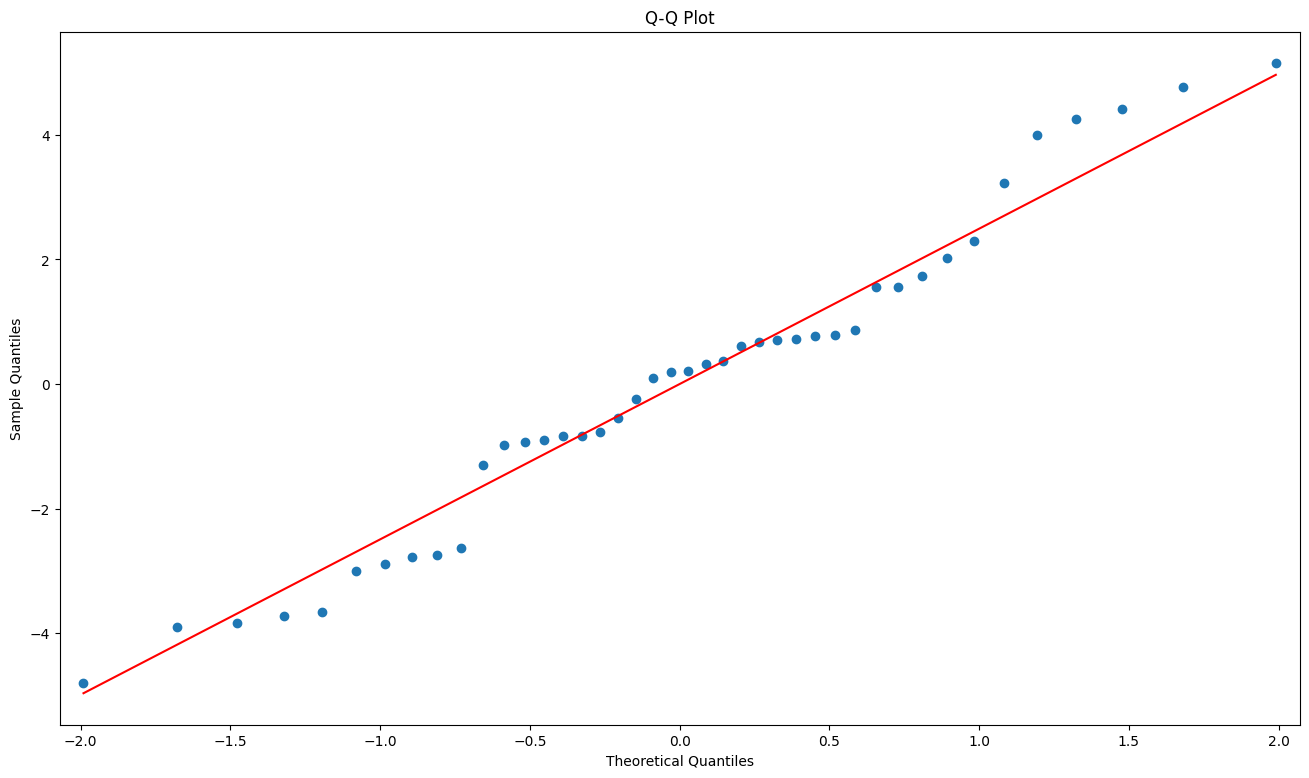

In [125]:
#shapiro-Wilk test of normality of residuals
results=results1

labels = ["Statistic", "p-value"]
norm_res = stats.shapiro(results.resid)

for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)
    ##if test is significant then the assumption is violated
        #not significant here - so that is good!

## Q-Q PLot
fig = plt.figure(figsize = (16, 9))
ax = fig.add_subplot(111)

sm.qqplot(results.resid, dist = stats.norm, line = 's', ax = ax)

ax.set_title("Q-Q Plot")

LM Statistic 22.096590665346792
LM-Test p-value 0.053883125901455296
F-Statistic 2.3911811296976095
F-Test p-value 0.02597073517664425


Text(0, 0.5, 'Residuals')

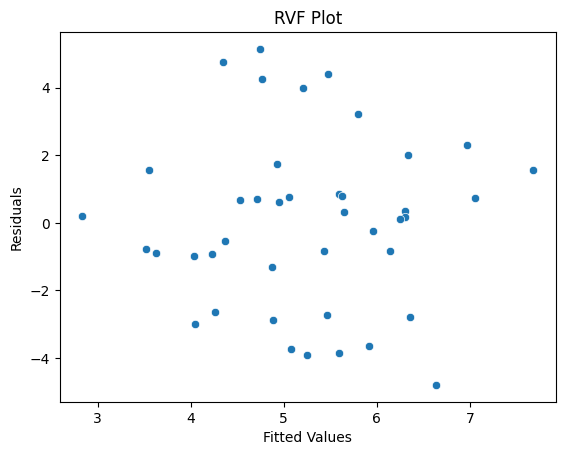

In [126]:
##homoskedasticity of variance 
#White Lagrange Multiplier Test for Heteroscedasticity
het_white_res = het_white(results.resid, results.model.exog)

labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]

for key, val in dict(zip(labels, het_white_res)).items():
    print(key, val)
    ##again, only violated if you get a significant p value (which we don't have here)

#RVF plot (residuals vs fitted values)
fig = plt.figure()
ax = sns.scatterplot(y = results.resid, x = results.fittedvalues)

ax.set_title("RVF Plot")
ax.set_xlabel("Fitted Values")
ax.set_ylabel("Residuals")

Also calculate Bayes factor for strenght of null

In [131]:
bayes_factor(task_summary, 'win_stay', 'Fear', 'Disgust')

3.6101083032490973

<b> MODEL 6: LOSE-SHIFT </b>

lose-shift  skew: 0.17518763450050448


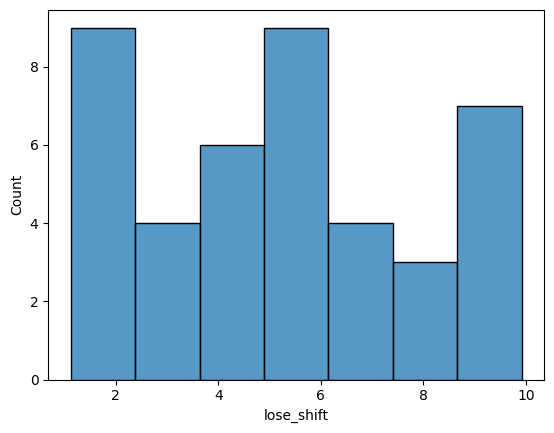

In [127]:
sns.histplot(data=task_summary, x="lose_shift") 
print('lose-shift  skew: '+str(skew(task_summary.win_stay, nan_policy='omit')))

Now run the hypothesis testing model (with any covariates that were significant in models 1 and 2)

In [128]:
data=task_summary.reset_index()
data=data.replace(['Disgust', 'Fear', 'Points'], [1.0,2.0,3.0])
formula = 'lose_shift ~ block_type+prolific_age+prolific_sex+digit_span'
md=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
results1 = md.fit()
print(results1.summary())

             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   lose_shift
No. Observations:    42        Method:               REML      
No. Groups:          14        Scale:                7.5689    
Min. group size:     3         Log-Likelihood:       -101.9669 
Max. group size:     3         Converged:            No        
Mean group size:     3.0                                       
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             5.705    1.797  3.174 0.002  2.182  9.228
prolific_sex[T.Male] -0.524    1.033 -0.507 0.612 -2.550  1.501
block_type            0.300    0.520  0.577 0.564 -0.719  1.319
prolific_age         -0.018    0.043 -0.429 0.668 -0.102  0.065
digit_span           -0.064    0.184 -0.351 0.726 -0.425  0.296
Group Var             0.187    0.645                 

C:\Users\eb08\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eb08\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\eb08\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eb08\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\eb08\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\mode

Next, perform post-hoc tests to interpret any significant results
(or none if there is nothing significant)

Test the assumptions of this model

Statistic 0.9667965668439806
p-value 0.2567617850642679


Text(0.5, 1.0, 'Q-Q Plot')

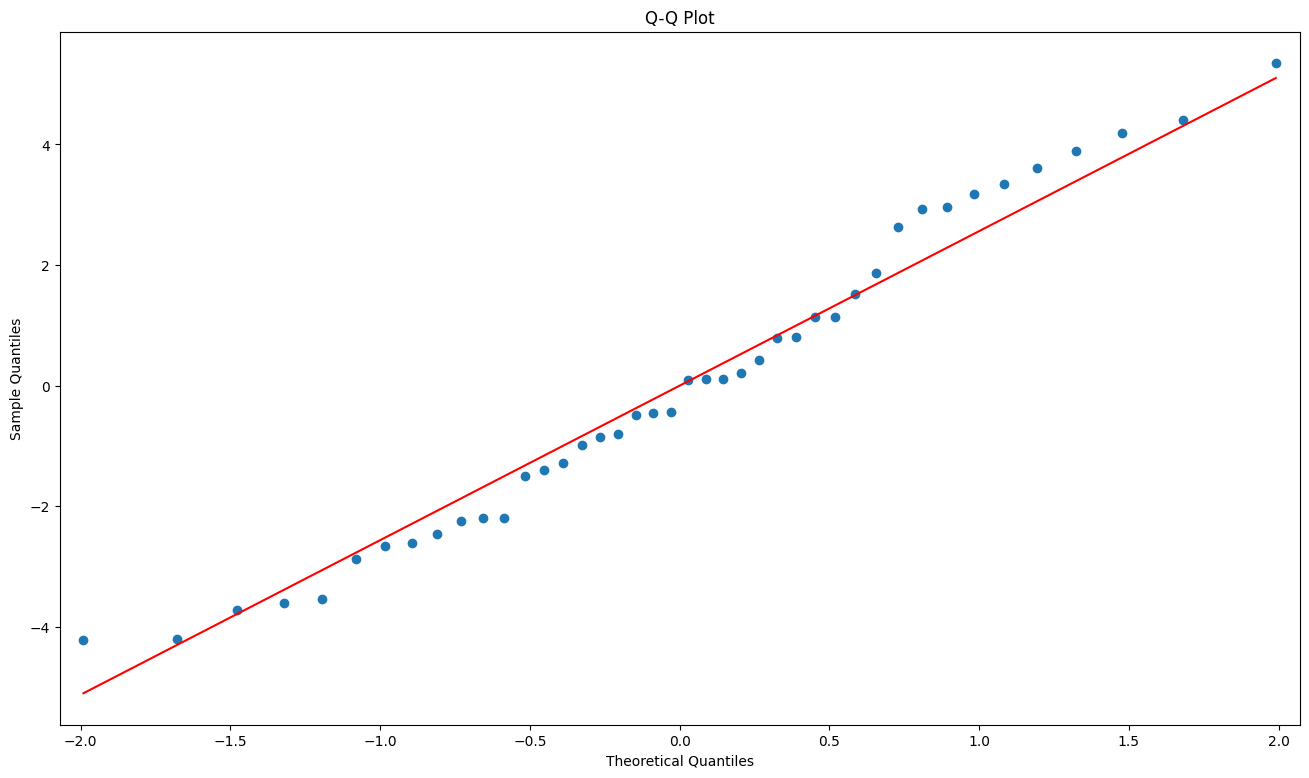

In [129]:
#shapiro-Wilk test of normality of residuals
results=results1

labels = ["Statistic", "p-value"]
norm_res = stats.shapiro(results.resid)

for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)
    ##if test is significant then the assumption is violated
        #not significant here - so that is good!

## Q-Q PLot
fig = plt.figure(figsize = (16, 9))
ax = fig.add_subplot(111)

sm.qqplot(results.resid, dist = stats.norm, line = 's', ax = ax)

ax.set_title("Q-Q Plot")

LM Statistic 11.254774766920391
LM-Test p-value 0.5894836824286963
F-Statistic 0.7884493660516311
F-Test p-value 0.6658610826475301


Text(0, 0.5, 'Residuals')

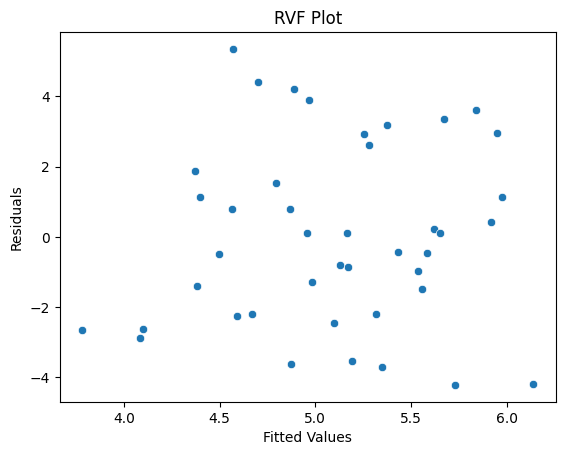

In [130]:
##homoskedasticity of variance 
#White Lagrange Multiplier Test for Heteroscedasticity
het_white_res = het_white(results.resid, results.model.exog)

labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]

for key, val in dict(zip(labels, het_white_res)).items():
    print(key, val)
    ##again, only violated if you get a significant p value (which we don't have here)

#RVF plot (residuals vs fitted values)
fig = plt.figure()
ax = sns.scatterplot(y = results.resid, x = results.fittedvalues)

ax.set_title("RVF Plot")
ax.set_xlabel("Fitted Values")
ax.set_ylabel("Residuals")

Calculate Bayes factor (if there is a null)

In [132]:
bayes_factor(task_summary, 'lose_shift', 'Fear', 'Points')

2.7777777777777777